# Introduction

- This project aims at building a **face mask detection model**.

## 1. Import and Understand the data

In [ ]:
import numpy as np

from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. A. Import and read ‘images.npy

In [ ]:
img_array = np.load('/content/drive/MyDrive/Colab Notebooks/Project_Data/CV/images.npy', allow_pickle=True)

In [ ]:
img_array.shape

(409, 2)

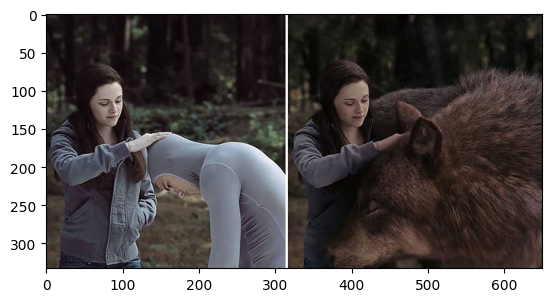

In [ ]:
plt.imshow(img_array[0][0])

In [ ]:
img_array[0,1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

### **1. B. Split the data into Features(X) & labels(Y). Unify shape of all the images**

- Let us find unique channel count for all the images.
- e.g. Images have 3 or 4 channels. One image is also in gray scale i.e. no channel.

In [ ]:
# Get channel info for all items
item_list = [item.shape[2] if item.ndim >= 3 else 1 for item in img_array[:,0]]

# Get the unique values from the channel count list
print(" Unique channel counts : ",np.unique(np.array(item_list)))

 Unique channel counts :  [1 3 4]


#### **Let us resize the images**

- Befor splitting the data, let us resize the images. Because the images are in various scales (pixel size and number os channels vary).
- Let us unify all the images with size as (224, 224, 3). This is the requirement of MobileNet model from Keras.


In [ ]:
from PIL import Image
import cv2

IMAGE_SIZE = 224
for index, img in enumerate(img_array[:,0]):
  img = Image.fromarray(img)
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')
  img_array[index,0] = np.array(img)


- The dataset, img_array, contains 2 parts - image data and annotation information
- Let us seperate all the images in input fetures variable i.e "X"
- Let us collect all the output labels in variable "y"

In [ ]:
X = img_array[:,0]

In [ ]:
X.shape

(409,)

In [ ]:
X[1].shape

(224, 224, 3)

- Let us create the output variable "y"
- Output of the model will be a mask image. The size of the mask image will be same as the size of original image.
- Let us create the mask images.

In [ ]:
img_array[:,1].shape

(409,)

In [ ]:
img_array[:,1][0]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

### **Define a function to create mask image**
- Input - Annotations
- Output - Masked Image
- Notes:
  - There can be multiple faces in the Annotation information.

In [ ]:
# Function : create_mask()
# Input : - 1. Original Image file
#         - 2. List of dictionary objects.
#         Each dictionary item contains 'points' key which has two the X,y coordinates.
#         imageWidth', 'imageHeight' keys contain the width & height of the image
#         imageWidth and Height is required to find actual coordinates of the left top and bottom right point of the bounding box.
# Output : Mask image, of the same Size as the original Image.

def create_mask(x, bb_list):

    # Creates a mask for the bounding box of same shape as image
    # All pixels would be 0

    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))

    imageWidth = IMAGE_SIZE
    imageHeight = IMAGE_SIZE

    # Loop through the bounding box list.
    # For each bounding box create the mask in the above image

    for bb in bb_list:

      # Convert the relative coordinates to actual coordinate values using the image width and height
      x1 = bb['points'][0]['x']
      y1 = bb['points'][0]['y']
      x2 = bb['points'][1]['x']
      y2 = bb['points'][1]['y']

      # if (IMAGE_SIZE == 0):
      #   imageWidth = bb['imageWidth']
      #   imageHeight = bb['imageHeight']
      # else:
      #   imageWidth = IMAGE_SIZE
      #   imageHeight = IMAGE_SIZE

      x1 = int(x1 * imageWidth)
      x2 = int(x2 * imageWidth)
      y1 = int(y1 * imageHeight)
      y2 = int(y2 * imageHeight)

      # Set the mask pixels as 1 in the image

      Y[y1:y2,x1:x2] = 1

    return Y

### **Create mask for all the images**

In [ ]:
y = [create_mask(img_array[:,0][index], anno_item) for index, anno_item in np.ndenumerate(img_array[:,1])]

### 1. C. Split the data into train and test[400:9]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42 )

In [ ]:
# y_train
print(X_train.shape,len(y_train),X_test.shape,len(y_test))

(400,) 400 (9,) 9


In [ ]:
X_train[0].shape, y_train[0].shape

((224, 224, 3), (224, 224))

### 1. D. Select random image from the train data and display original image and masked image

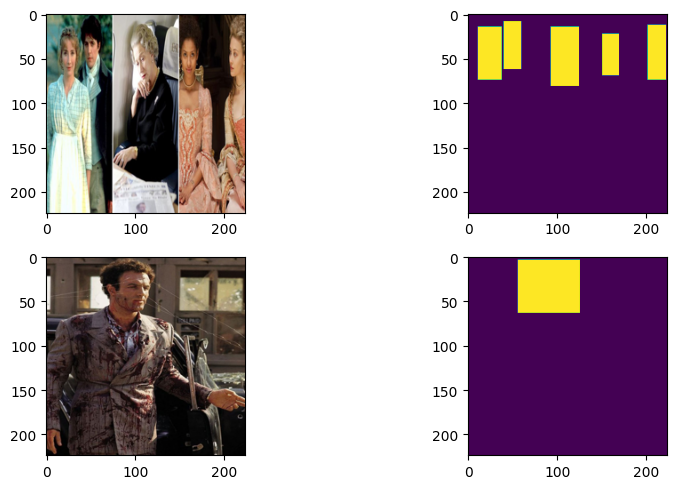

In [ ]:
fig = plt.figure(figsize=(10, 5))

plot_cnt = 1
for index in range(2):
   ax1 = plt.subplot(2, 2, plot_cnt)
   ax2 = plt.subplot(2, 2, plot_cnt+1)
   ax1.imshow(X_train[index])
   ax2.imshow(y_train[index])
   plot_cnt = plot_cnt + 2

plt.tight_layout()
plt.show()

### Change the output size to (28,28) from (224,224)

In [ ]:
from PIL import Image
import cv2

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

# Change the size of train outputs
for index, img in enumerate(y_train):
  img = Image.fromarray(img)
  img = img.resize((HEIGHT_CELLS, WIDTH_CELLS)) # Resize image
  y_train[index] = np.array(img)

# Change the size of test outputs
for index, img in enumerate(y_test):
  img = Image.fromarray(img)
  img = img.resize((HEIGHT_CELLS, WIDTH_CELLS)) # Resize image
  y_test[index] = np.array(img)

### Let us check the mask images

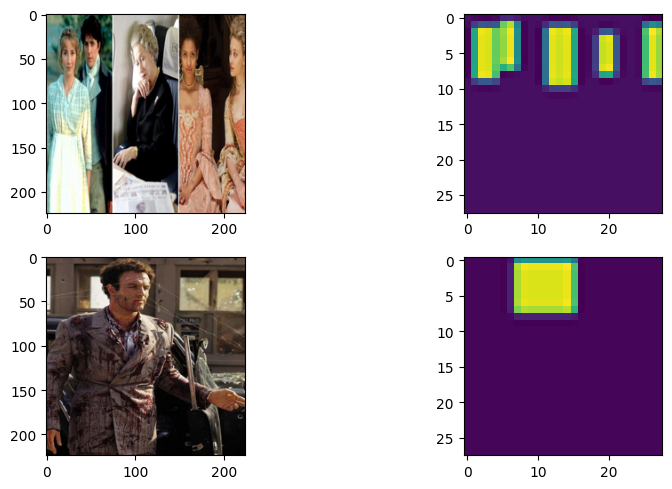

In [ ]:
fig = plt.figure(figsize=(10, 5))

plot_cnt = 1
for index in range(2):
   ax1 = plt.subplot(2, 2, plot_cnt)
   ax2 = plt.subplot(2, 2, plot_cnt+1)
   ax1.imshow(X_train[index])
   ax2.imshow(y_train[index])
   plot_cnt = plot_cnt + 2

plt.tight_layout()
plt.show()

In [ ]:
y_train[0].shape

(28, 28)

## 2. Model building

In [ ]:
! pip install tensorflow==2.8

In [ ]:
import tensorflow
tensorflow.__version__

'2.8.0'

In [ ]:
import random
random.seed(0)

In [ ]:
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [ ]:
# Convert images to float type for both train and test data

from PIL import Image
from keras.applications.mobilenet import preprocess_input

def ConvertToFloat(img_list):
  for index, img in enumerate(img_list):
    img = Image.fromarray(img)
    img_list[index] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array

ConvertToFloat(X_train)
ConvertToFloat(y_train)
ConvertToFloat(X_test)
ConvertToFloat(y_test)

### 2. A. Design a face mask detection model

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

    return Model(inputs=model.input, outputs=x)

### 2. B. Design your own Dice Coefficient and Loss function.

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

#### Define loss function

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

### 2. C. Train and tune the model as required.

In [ ]:
model = create_model(False)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

### Compile the model

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy

optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define callbacks

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

### Fit the model

In [ ]:
callbacklist=[reduce_lr,early_stopping]

In [ ]:
def convertToTensor(img_array):
  img_list = img_array.tolist()

  # Convert the list to a TensorFlow tensor
  img_tensor = tensorflow.constant(img_list, dtype=tensorflow.float32)

  return img_tensor

#### Let us split the data into train and validation set

In [ ]:
from sklearn.model_selection import train_test_split
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.01, random_state=42 )

In [ ]:
y_train_split = np.array(y_train_split)
y_val = np.array(y_val)
X_train_split.shape, X_val.shape, y_train_split.shape, y_val.shape

((396,), (4,), (396, 28, 28), (4, 28, 28))

In [ ]:
X_train_split = convertToTensor(X_train_split)
y_train_split = convertToTensor(y_train_split)
X_val_temp = convertToTensor(X_val)
y_val_temp = convertToTensor(y_val)

In [ ]:
history = model.fit(X_train_split,y_train_split, validation_data = (X_val_temp,y_val_temp), epochs=15, batch_size=32, verbose=1,callbacks=callbacklist)

Epoch 1/15
13/13 [==============================] - 4s 145ms/step - loss: -1.1655 - dice_coefficient: 0.4366 - val_loss: -1.6627 - val_dice_coefficient: 0.1709 - lr: 1.0000e-04
Epoch 2/15
13/13 [==============================] - 1s 49ms/step - loss: -1.7358 - dice_coefficient: 0.1690 - val_loss: -2.1087 - val_dice_coefficient: 0.0667 - lr: 1.0000e-04
Epoch 3/15
13/13 [==============================] - 1s 48ms/step - loss: -2.1989 - dice_coefficient: 0.0727 - val_loss: -2.5289 - val_dice_coefficient: 0.0290 - lr: 1.0000e-04
Epoch 4/15
13/13 [==============================] - 1s 48ms/step - loss: -2.6666 - dice_coefficient: 0.0348 - val_loss: -3.0216 - val_dice_coefficient: 0.0142 - lr: 1.0000e-04
Epoch 5/15
13/13 [==============================] - 1s 48ms/step - loss: -3.2230 - dice_coefficient: 0.0184 - val_loss: -3.6144 - val_dice_coefficient: 0.0077 - lr: 1.0000e-04
Epoch 6/15
13/13 [==============================] - 1s 47ms/step - loss: -3.8811 - dice_coefficient: 0.0117 - val_loss:

In [ ]:
[name for name in history.history.keys()]

['loss', 'dice_coefficient', 'val_loss', 'val_dice_coefficient', 'lr']

### 2. D. Evaluate and share insights on performance of the model.

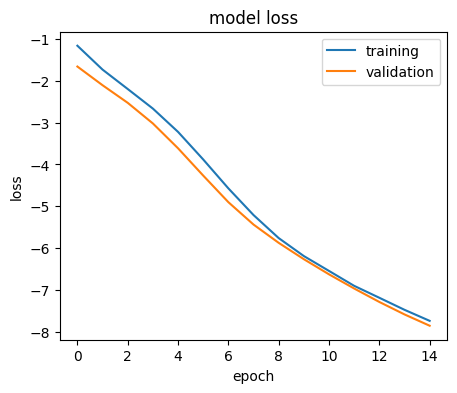

In [ ]:
fig = plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

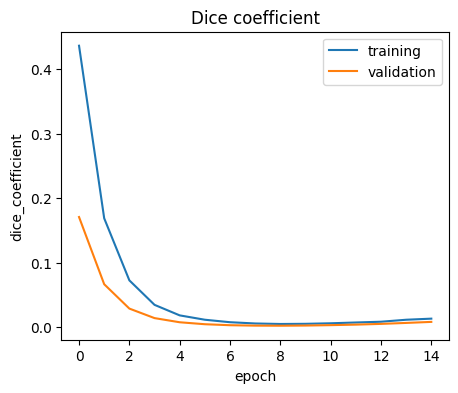

In [ ]:
fig = plt.figure(figsize=(5, 4))
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('Dice coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

- The model has very low accuracy.
- It needs to be tunned for better performance.

## 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image